<div align="center">
	<h1>CS 328: Introduction to Data Science</h1>
	<h2>Assignment 2</h2>
	Shardul Junagade <br>
	23110297
</div>

### Importing Libraries

In [ ]:
import os
import csv
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
seed = 0
np.random.seed(seed)

from scipy.sparse import lil_matrix, linalg, csgraph
from sklearn.cluster import KMeans

In [48]:
save_dir = "./assets/assignment2/"
ques = ["Q1/", "Q2/", "Q3/", "Q4/"]
save_dirs = [save_dir + q for q in ques]
for save_dir in save_dirs:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

## Question 1

Q1. Implement the greedy algorithm for the densest subgraph. Run your algorithm on the [linked dataset](https://snap.stanford.edu/data/facebook-large-page-page-network.html). Report the density of the component extracted, as well as the histogram of the page categories in the densest subgraph. Also report the overall histogram of page categories and comment on how similar/different the two histograms are. Also compare its density with the density of the whole graph.


In [49]:
facebook_root = "./data/facebook_large/"
target_file = facebook_root + "musae_facebook_target.csv"
edges_file = facebook_root + "musae_facebook_edges.csv"

In [ ]:
node_attrs = {}
with open(target_file, newline='', encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        node_attrs[int(row['id'])] = {
            'facebook_id': row['facebook_id'],
            'page_name': row['page_name'],
            'page_type': row['page_type']
        }
num_nodes = len(node_attrs)
print(f"Number of nodes (loaded from target file): {num_nodes}")

edges_df = pd.read_csv(edges_file)
num_nodes = max(edges_df['id_1'].max(), edges_df['id_2'].max()) + 1
print(f"Number of nodes (determined from edges file): {num_nodes}")

adj_matrix = lil_matrix((num_nodes, num_nodes), dtype=np.int8)
for src, dst in tqdm(zip(edges_df['id_1'], edges_df['id_2']), total=len(edges_df), desc="Loading edges"):
    adj_matrix[src, dst] = 1
    adj_matrix[dst, src] = 1

# Convert to CSR format for faster operations
adj_matrix = adj_matrix.tocsr()
print(f"\nAdjacency matrix shape: {adj_matrix.shape}")

# check number of edges in adjacency matrix, also count self loops 
num_edges = adj_matrix.sum() // 2 + adj_matrix.diagonal().sum() // 2
print(f"Number of edges (in adjacency matrix): {num_edges}")
# check number of nodes in adjacency matrix
print(f"Number of nodes (in adjacency matrix): {adj_matrix.shape[0]}")

Number of nodes (loaded from target file): 22470
Number of nodes (determined from edges file): 22470


Loading edges: 100%|██████████| 171002/171002 [00:01<00:00, 116038.04it/s]



Adjacency matrix shape: (22470, 22470)
Number of edges (in adjacency matrix): 171001
Number of nodes (in adjacency matrix): 22470


In [51]:
# different categories of page types
page_types = set()
for node in node_attrs.values():
    page_types.add(node['page_type'])
page_types = sorted(list(page_types))
print(f"Page types: {page_types}")

Page types: ['company', 'government', 'politician', 'tvshow']


In [52]:
# Compute graph density
def calculate_density(adj_matrix, active_mask=None):
    if active_mask is None:
        active_mask = np.ones(adj_matrix.shape[0], dtype=bool)
    num_active_nodes = active_mask.sum()
    if num_active_nodes == 0:
        return 0.0
    num_edges = adj_matrix[active_mask][:, active_mask].sum() / 2
    return num_edges / num_active_nodes

# Greedy densest subgraph algorithm
def greedy_densest_subgraph(adj_matrix):
    active_mask = np.ones(num_nodes, dtype=bool)
    degrees = degrees = adj_matrix.sum(axis=1).astype(float)  # Ensure float dtype
    max_density = calculate_density(adj_matrix, active_mask)
    best_active_mask = active_mask.copy()
    removal_order = []
    densities = [max_density]
    
    with tqdm(total=num_nodes, desc="Removing nodes") as pbar:
        while active_mask.sum() > 0:
            min_degree_node = np.argmin(degrees)
            active_mask[min_degree_node] = False  # Remove node
            neighbors = adj_matrix[min_degree_node].nonzero()[1]
            degrees[neighbors] -= 1  # Update degrees
            degrees[min_degree_node] = np.inf  # Mark removed node
            removal_order.append(min_degree_node)
            
            current_density = calculate_density(adj_matrix, active_mask)
            densities.append(current_density)
            if current_density > max_density:
                max_density = current_density
                best_active_mask = active_mask.copy()
            
            pbar.set_postfix_str(f"Best density: {max_density:.4f}")
            pbar.update(1)
    
    return best_active_mask, max_density, removal_order, densities

In [ ]:
run_greedy = False  # Set to True to run the greedy algorithm, False to load results (for the sake of time)
if run_greedy:
    best_active_mask, max_density, removal_order, densities = greedy_densest_subgraph(adj_matrix)
    np.save(save_dirs[0] + "best_active_mask.npy", best_active_mask)
    np.save(save_dirs[0] + "removal_order.npy", removal_order)
    np.save(save_dirs[0] + "densities.npy", densities)
else:
    best_active_mask = np.load(save_dirs[0] + "best_active_mask.npy")
    best_active_mask = best_active_mask.astype(bool)
    removal_order = np.load(save_dirs[0] + "removal_order.npy")
    densities = np.load(save_dirs[0] + "densities.npy")
    max_density = densities.max()

Densest Subgraph Staatistics:
    Number of nodes: 320
    Number of edges: 11201
    Density: 35.003125


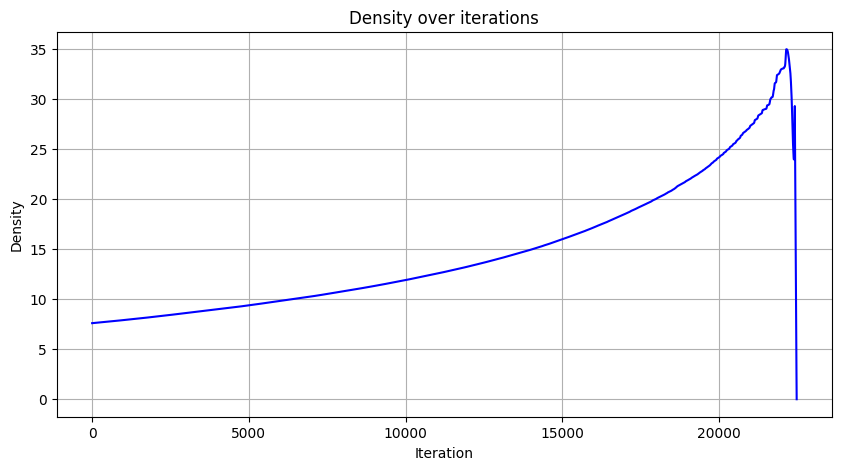

In [54]:
print("Densest Subgraph Staatistics:")
print(f"    Number of nodes: {best_active_mask.sum()}")
print(f"    Number of edges: {int(adj_matrix[best_active_mask][:, best_active_mask].sum() / 2)}")
print(f"    Density: {max_density}")
# print(f"    Removal order: {list(removal_order)}")

# Plotting the density over iterations
plt.figure(figsize=(10, 5))
plt.plot(densities, color='blue')
plt.title('Density over iterations')
plt.xlabel('Iteration')
plt.ylabel('Density')
plt.grid()
plt.savefig(save_dirs[0] + "density_over_iterations.png", dpi=300)
plt.show()

In [55]:
print(f"Density of the entire graph    : {calculate_density(adj_matrix):.4f}")
print(f"Density of the densest subgraph: {max_density:.4f}")

Density of the entire graph    : 7.6063
Density of the densest subgraph: 35.0031


Category counts in the whole graph:
    company: 6495
    government: 6880
    politician: 5768
    tvshow: 3327
Category counts in the densest subgraph:
    company: 4
    government: 256
    politician: 0
    tvshow: 60


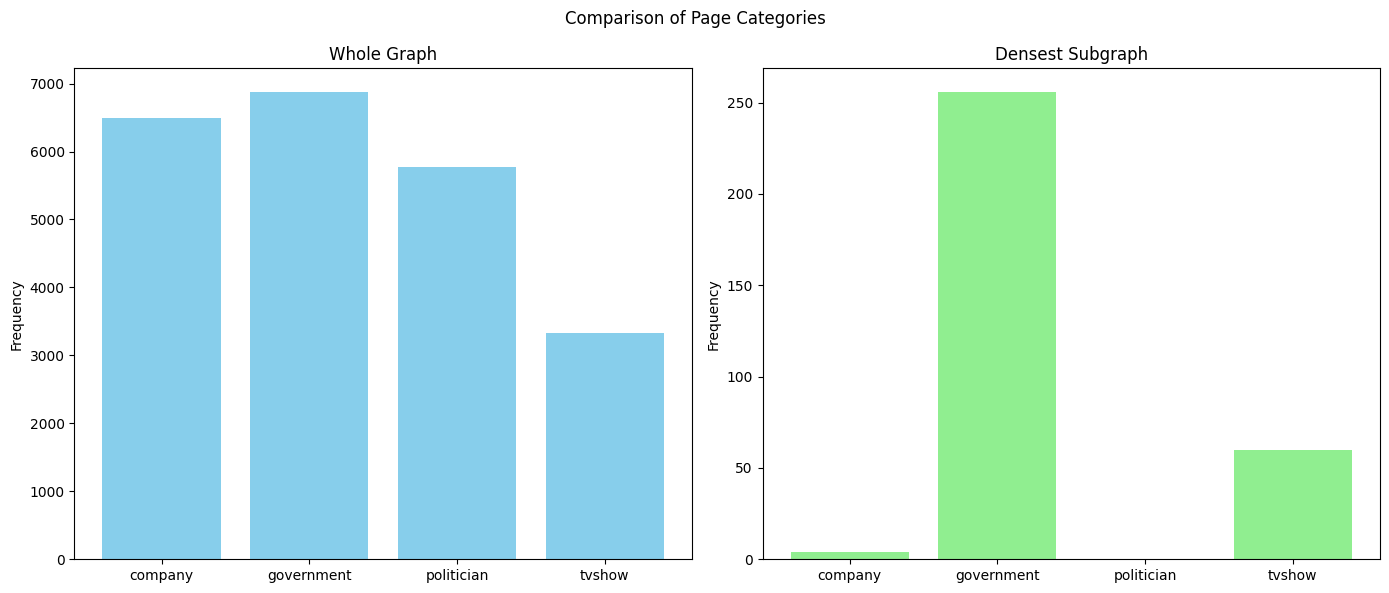

In [ ]:
def plot_category_histograms(node_attrs, full_mask, densest_mask, save_path):
    # Extract category counts
    full_categories = [node_attrs[node]['page_type'] for node in np.where(full_mask)[0]]
    densest_categories = [node_attrs[node]['page_type'] for node in np.where(densest_mask)[0]]
    full_counts = Counter(full_categories)
    densest_counts = Counter(densest_categories)
    
    # Ensure both histograms have the same categories
    all_categories = sorted(set(full_counts.keys()).union(set(densest_counts.keys())))
    full_freqs = [full_counts.get(cat, 0) for cat in all_categories]
    densest_freqs = [densest_counts.get(cat, 0) for cat in all_categories]

    # Print category counts
    print("Category counts in the whole graph:")
    for cat, count in zip(all_categories, full_freqs):
        print(f"    {cat}: {count}")
    print("Category counts in the densest subgraph:")
    for cat, count in zip(all_categories, densest_freqs):
        print(f"    {cat}: {count}")

    # Plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))             # I had added sharey=True to share y-axis between subplots, but the values in second subplot are too small to be visible.
    axes[0].bar(all_categories, full_freqs, color='skyblue')
    axes[0].set_title("Whole Graph")
    axes[0].set_ylabel("Frequency")
    axes[1].bar(all_categories, densest_freqs, color='lightgreen')
    axes[1].set_title("Densest Subgraph")
    axes[1].set_ylabel("Frequency")
    fig.suptitle("Comparison of Page Categories")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_category_histograms(node_attrs, np.ones(num_nodes, dtype=bool), best_active_mask, save_dirs[0] + "category_histogram_comparison.png")

## Question 2

Q2. Consider the email communication dataset [linked here](https://snap.stanford.edu/data/email-Eu-core.html). Use it as an undirected network. Nodes are tagged with departments. Consider each department as a set and calculate both its density ($\rho$) and conductance ($\phi$). Find out the sparsest cut as given by the second eigenvector of the normalized Laplacian and report its conductance ($\phi_{\text{cut}}$). Also report the histogram of departments in the sparsest cut.

In [ ]:
email_dir = "./data/email-Eu-core/"
edge_file = email_dir + "email-Eu-core.txt"
label_file = email_dir + "email-Eu-core-department-labels.txt"

# Read the edge list and labels
edges = pd.read_csv(edge_file, sep=" ", header=None, names=["id_1", "id_2"], dtype=int)
labels = pd.read_csv(label_file, sep=" ", header=None, names=["id", "label"], dtype=int)
labels = labels["label"].values

num_members = len(labels)
num_departments = len(set(labels))
print(f"Number of members: {num_members}")
print(f"Number of edges: {len(edges)}")
print(f"Number of departments: {num_departments}")

dept_masks = {}
for i in range(num_departments):
    dept_masks[i] = np.zeros(num_members, dtype=bool)
for i in range(num_members):
    dept_masks[labels[i]][i] = True


Number of members: 1005
Number of edges: 25571
Number of departments: 42


In [ ]:
adj_matrix = lil_matrix((num_members, num_members), dtype=np.int8)
for _, row in tqdm(edges.iterrows(), total=len(edges)):
    adj_matrix[row["id_1"], row["id_2"]] = 1
    adj_matrix[row["id_2"], row["id_1"]] = 1
adj_matrix = adj_matrix.tocsr()
print(f"Adjacency matrix shape: {adj_matrix.shape}")

# Calculate the degree of each node
degrees = np.array(adj_matrix.sum(axis=1)).flatten()

100%|██████████| 25571/25571 [00:01<00:00, 15970.98it/s]

Adjacency matrix shape: (1005, 1005)


In [ ]:
def calculate_density(adj_matrix, mask=None):
    if mask is None:
        mask = np.ones(adj_matrix.shape[0], dtype=bool)
    num_nodes = np.sum(mask)
    num_edges = adj_matrix[mask][:, mask].sum() / 2
    max_edges = num_nodes * (num_nodes - 1) / 2
    density = num_edges / max_edges if max_edges > 0 else 0.0
    return density

def calculate_conductance(adj_matrix, degrees, mask=None):
    if mask is None:
        raise ValueError("Mask cannot be None for conductance calculation.")
    num_nodes = np.sum(mask)
    if num_nodes == 0:
        return 0.0
    cut_edges = adj_matrix[mask][:, ~mask].sum()
    vol_s = np.sum(degrees[mask])
    vol_s_complement = np.sum(degrees[~mask])
    conductance = cut_edges / min(vol_s, vol_s_complement) if min(vol_s, vol_s_complement) > 0 else 0.0
    return conductance

def calculate_sparsest_cut(adj_matrix, degrees):
    laplacian = csgraph.laplacian(adj_matrix, normed=True)                  # Normalized Laplacian
    eigenvalues, eigenvectors = linalg.eigsh(laplacian, k=2, which='SM')    # Get the first two eigenvalues and eigenvectors 
    second_smallest_eigenvector = np.real(eigenvectors[:, 1])
    sorted_indices = np.argsort(second_smallest_eigenvector)
    best_conductance = float('inf')
    best_cut_idx = None
    for i in range(1, len(sorted_indices)):
        cut_mask = np.zeros(num_members, dtype=bool)
        cut_mask[sorted_indices[:i]] = True
        conductance = calculate_conductance(adj_matrix, degrees, cut_mask)
        if conductance < best_conductance:
            best_conductance = conductance
            best_cut_idx = i
    cut_mask = np.zeros(num_members, dtype=bool)
    cut_mask[sorted_indices[:best_cut_idx]] = True
    complement_mask = ~cut_mask
    return cut_mask, complement_mask, best_conductance

def calculate_histogram(labels, departments, mask=None):
    if mask is None:
        mask = np.ones(num_members, dtype=bool)
    cut_labels = labels[mask]
    label_counts = Counter(cut_labels)
    histogram = np.zeros(len(departments), dtype=int)
    for label, count in label_counts.items():
        histogram[label] = count
    return histogram, label_counts

In [ ]:
# Calculate density and conductance for each department
densities = []
conductances = []
for i in range(num_departments):
    mask = dept_masks[i]
    density = calculate_density(adj_matrix, mask)
    conductance = calculate_conductance(adj_matrix, degrees, mask)
    densities.append(density)
    conductances.append(conductance)

department_df = pd.DataFrame({
    "Department": range(num_departments),
    "Density": densities,
    "Conductance": conductances
})
department_df.to_csv(save_dirs[1] + "department_density_conductance.csv", index=False)

print("Department-wise Density and Conductance:")
display(department_df)

Department-wise Density and Conductance:


,Department,Density,Conductance
0,0,0.235544,0.544033
1,1,0.168029,0.581688
2,2,0.611111,0.757709
3,3,0.515152,0.774834
4,4,0.132348,0.548013
5,5,0.637255,0.742404
6,6,0.068783,0.876190
7,7,0.355294,0.429830
8,8,0.532164,0.699670
9,9,0.195565,0.707831


In [ ]:
# Calculate the sparsest cut and its conductance
cut_mask, complement_mask, best_conductance = calculate_sparsest_cut(adj_matrix, degrees)
np.save(save_dirs[1] + "sparsest_cut_mask.npy", cut_mask)
print(f"Conductance of the sparsest cut: {best_conductance:.4f}")
print(f"Partition sizes: {np.sum(cut_mask)}, {np.sum(complement_mask)}")

Conductance of the sparsest cut: 0.2654
Partition sizes: 82, 923


Counts of departments in the sparsest cut:
    Department 14: 81
    Department 32: 1

Histogram of departments in the sparsest cut:


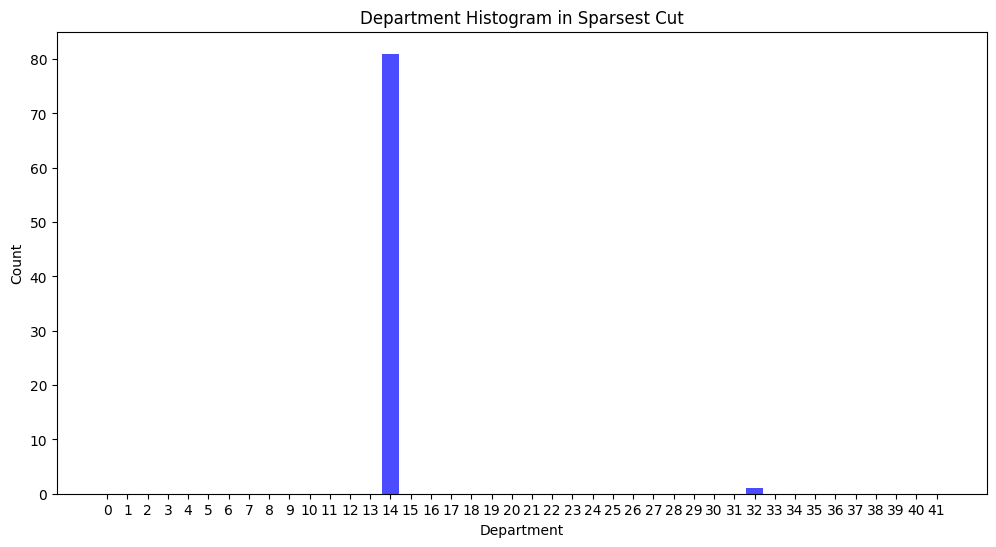

In [ ]:
sparse_cut_dept_histogram, sparse_cut_label_counts = calculate_histogram(labels, range(num_departments), cut_mask)
print("Counts of departments in the sparsest cut:")
for label, count in sparse_cut_label_counts.items():
    print(f"    Department {label}: {count}")

print("\nHistogram of departments in the sparsest cut:")
plt.figure(figsize=(12, 6))
plt.bar(range(num_departments), sparse_cut_dept_histogram, color='blue', alpha=0.7)
plt.xlabel("Department")
plt.ylabel("Count")
plt.title("Department Histogram in Sparsest Cut")
plt.xticks(range(num_departments))
plt.savefig(save_dirs[1] + "sparsest_cut_histogram.png", dpi=300)
plt.show()

## Question 3

Q3. Create a 1-dimensional dataset in the following manner – pick 100 samples from each of following two Gaussians.

<div style="margin-left: 25px;">
(a) mean = 0, variance = 1. 
<br> 
(b) mean = 3, variance = 1.  
</div>

Use sklearn’s implementation for kmeans. First try k-means on this data using $k = 2$. What are the centers? What fraction of points are correctly classified?

Now, suppose we want to use distance rather than squared distance (i.e., k-median). Let us do an exhaustive search over all 2-clusterings (left $s$ points in one cluster and rest $200 - s$ in the other cluster). Find the best one according to the k-median objective. What are the centers? Did distance work better or the squared distance?

In [ ]:
samples_a = np.random.normal(loc=0, scale=1, size=100)
samples_b = np.random.normal(loc=3, scale=1, size=100)
X = np.concatenate((samples_a, samples_b)).reshape(-1, 1)
y = np.array([0]*100 + [1]*100)
np.save(save_dirs[2] + "X.npy", X)

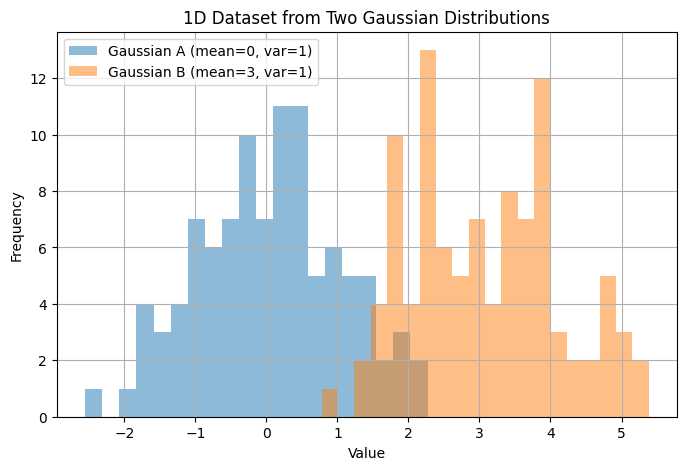

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(samples_a, bins=20, alpha=0.5, label='Gaussian A (mean=0, var=1)')
plt.hist(samples_b, bins=20, alpha=0.5, label='Gaussian B (mean=3, var=1)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('1D Dataset from Two Gaussian Distributions')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "two_gaussians.png", dpi=300)
plt.show()

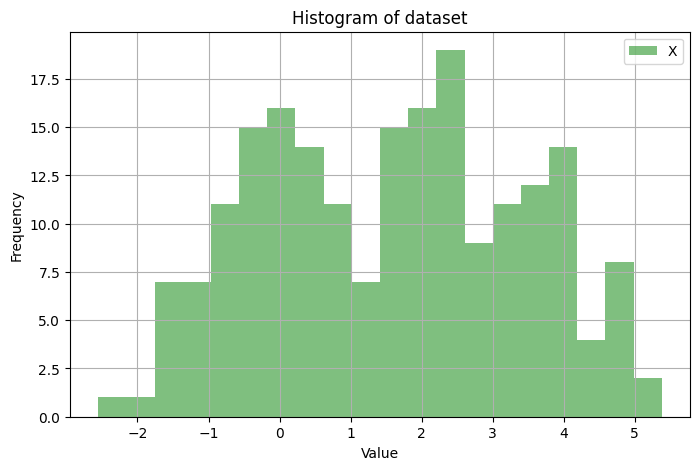

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(X, bins=20, label="X", color='green', alpha=0.5)
plt.title('Histogram of dataset')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "X_histogram.png", dpi=300)
plt.show()

#### K-means clustering

In [ ]:
# Q3.1. K-means clustering
kmeans = KMeans(n_clusters=2, random_state=seed)
kmeans.fit(X)
kmeans_centers = kmeans.cluster_centers_
y_pred_kmeans = kmeans.labels_

if kmeans_centers[0] > kmeans_centers[1]:
    kmeans_centers = kmeans_centers[::-1]
    y_pred_kmeans = 1 - y_pred_kmeans

K-means clustering centers: [-0.04362771  3.06125345]
True centers: [0, 3]
Fraction of points correctly classified: 0.94
Accuracy: 94.00%


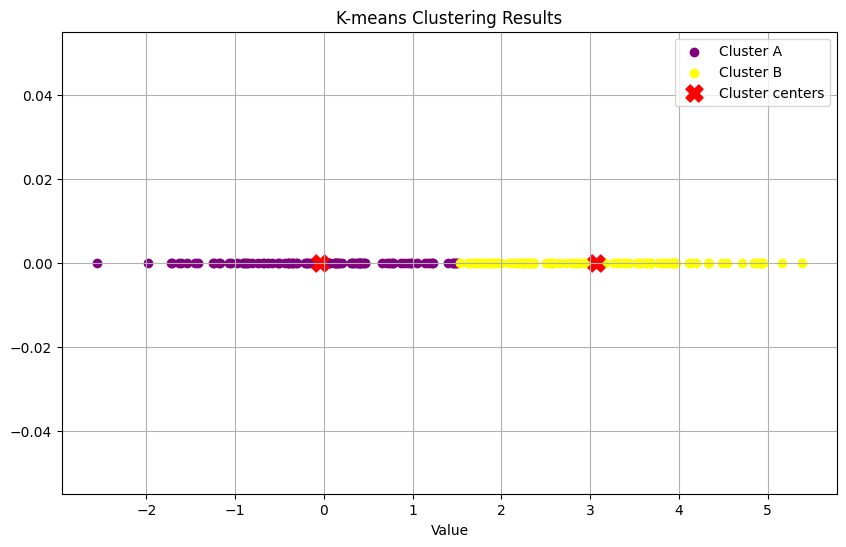

In [ ]:
kmeans_accuracy = np.sum(y == y_pred_kmeans) / len(y)
print(f"K-means clustering centers: {np.sort(kmeans_centers.flatten())}")
print(f"True centers: [0, 3]")
print(f"Fraction of points correctly classified: {kmeans_accuracy:.2f}")
print(f"Accuracy: {kmeans_accuracy*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.scatter(X[y_pred_kmeans == 0], np.zeros_like(X[y_pred_kmeans == 0]), c='purple', marker='o', label='Cluster A')
plt.scatter(X[y_pred_kmeans == 1], np.zeros_like(X[y_pred_kmeans == 1]), c='yellow', marker='o', label='Cluster B')
plt.scatter(kmeans_centers, np.zeros_like(kmeans_centers), c='red', marker='X', s=150, label='Cluster centers')
plt.title('K-means Clustering Results')
plt.xlabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "kmeans_clustering.png", dpi=300)
plt.show()

#### Exhaustive search for k-median clustering 

In [ ]:
# Calculate the k-median objective for a given clustering
def k_median_split(X, s):
    X_sorted = np.sort(X.flatten())
    cluster_a = X_sorted[:s]
    cluster_b = X_sorted[s:]
    center_a = np.median(cluster_a)
    center_b = np.median(cluster_b)
    if center_a > center_b:
        center_a, center_b = center_b, center_a
        cluster_a, cluster_b = cluster_b, cluster_a
    cost = np.sum(np.abs(cluster_a - center_a)) + np.sum(np.abs(cluster_b - center_b))
    return cost, np.array([center_a, center_b]).flatten(), (cluster_a, cluster_b)

# Perform exhaustive search over all possible 2-clusterings
n = len(X)
kmedians_cost = float('inf')
kmedians_centers = None
best_split = None

for s in tqdm(range(1, n), desc="Searching for best k-median split", ncols=100):
    cost, centers, clusters = k_median_split(X, s)
    if cost < kmedians_cost:
        kmedians_cost = cost
        best_split = s
        kmedians_centers = centers

print(f"\nBest k-median clustering centers: {np.sort(kmedians_centers)}")
print(f"True centers: [0, 3]")
print(f"Best k-median clustering split: {best_split}")
print(f"Best k-median clustering cost: {kmedians_cost:.2f}")

Searching for best k-median split: 100%|████████████████████████| 199/199 [00:00<00:00, 6989.80it/s]


Best k-median clustering centers: [-0.0088411   2.84767768]
True centers: [0, 3]
Best k-median clustering split: 90
Best k-median clustering cost: 160.10


Fraction of points correctly classified: 0.95
Accuracy: 95.00%


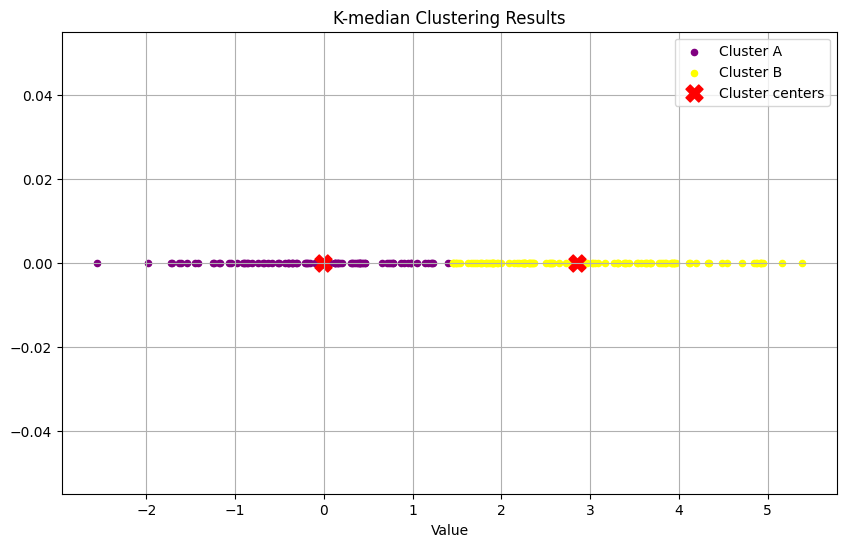

In [ ]:
y_pred_kmedians = np.zeros(n, dtype=int)
y_pred_kmedians[:best_split] = 0
y_pred_kmedians[best_split:] = 1
kmedians_accuracy = np.sum(y == y_pred_kmedians) / len(y)
print(f"Fraction of points correctly classified: {kmedians_accuracy:.2f}")
print(f"Accuracy: {kmedians_accuracy*100:.2f}%")

X_sorted = np.sort(X.flatten())
plt.figure(figsize=(10, 6))
plt.scatter(X_sorted[y_pred_kmedians == 0], np.zeros_like(X_sorted[y_pred_kmedians == 0]), c='purple', marker='o', s=20, label='Cluster A')
plt.scatter(X_sorted[y_pred_kmedians == 1], np.zeros_like(X_sorted[y_pred_kmedians == 1]), c='yellow', marker='o', s=20, label='Cluster B')
plt.scatter(kmedians_centers, np.zeros_like(kmedians_centers), c='red', marker='X', s=150, label='Cluster centers')
plt.title('K-median Clustering Results')
plt.xlabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "kmedian_clustering.png", dpi=300)
plt.show()

In [ ]:
print("Comparison of K-means and K-median:")

print(f"\nK-means centers: {np.sort(kmeans_centers.flatten())}")
print(f"K-median centers: {np.sort(kmedians_centers.flatten())}")
print(f"True centers: [0, 3]")

print(f"\nK-means accuracy: {kmeans_accuracy*100:.2f}%")
print(f"K-median accuracy: {kmedians_accuracy*100:.2f}%")

print(f"\nK-means cost (squared distance): {kmeans.inertia_:.2f}")
print(f"K-median cost (absolute distance): {kmedians_cost:.2f}")

print("\nBetter clustering method:", end="")
if kmeans.inertia_ < kmedians_cost:
    print("K-means")
else:
    print("K-median")

Comparison of K-means and K-median:

K-means centers: [-0.04362771  3.06125345]
K-median centers: [-0.0088411   2.84767768]
True centers: [0, 3]

K-means accuracy: 94.00%
K-median accuracy: 95.00%

K-means cost (squared distance): 184.08
K-median cost (absolute distance): 160.10

Better clustering method:K-median


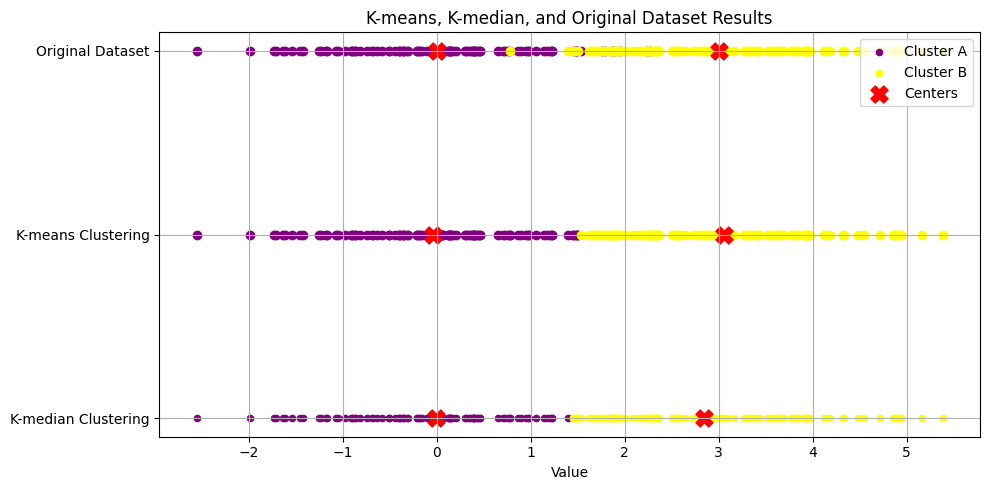

In [ ]:
plt.figure(figsize=(10, 5))
# Plot the original dataset (shifted to y = 2)
pos = 2
plt.scatter(samples_a, np.full_like(samples_a, pos), c='purple', marker='o')
plt.scatter(samples_b, np.full_like(samples_b, pos), c='yellow', marker='o')
plt.scatter([0, 3], np.full_like([0, 3], pos), c='red', marker='X', s=150)
# Plot K-means clustering (shifted to y = 1)
pos = 1
plt.scatter(X[y_pred_kmeans==0], np.full_like(X[y_pred_kmeans==0], pos), c='purple', marker='o')
plt.scatter(X[y_pred_kmeans==1], np.full_like(X[y_pred_kmeans==1], pos), c='yellow', marker='o')
plt.scatter(kmeans_centers, np.full_like(kmeans_centers, pos), c='red', marker='X', s=150)
# Plot K-median clustering (shifted to y = 0)
pos = 0
X_sorted = np.sort(X.flatten())
plt.scatter(X_sorted[y_pred_kmedians==0], np.full_like(X_sorted[y_pred_kmedians==0], pos), c='purple', marker='o', s=20, label='Cluster A')
plt.scatter(X_sorted[y_pred_kmedians==1], np.full_like(X_sorted[y_pred_kmedians==1], pos), c='yellow', marker='o', s=20, label='Cluster B')
plt.scatter(kmedians_centers, np.full_like(kmedians_centers, pos), c='red', marker='X', s=150, label='Centers')
plt.title('K-means, K-median, and Original Dataset Results')
plt.xlabel('Value')
plt.yticks([2, 1, 0], ['Original Dataset', 'K-means Clustering', 'K-median Clustering'])
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig(save_dirs[2] + "combined_results.png", dpi=300)
plt.show()